In [1]:
#!pip install deeplake

In [10]:
import tensorflow as tf
import deeplake
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.pyplot as plt



## Importing the Data

In [3]:

ds_train = deeplake.load("hub://activeloop/animal10n-train")
ds_test = deeplake.load("hub://activeloop/animal10n-test")

x_data = ds_train["images"]
x_data = np.reshape(x_data, (x_data.shape[0], 64, 64, 3))
x_data = x_data.astype("float32") / 255.0

y_data = ds_train["labels"]
num_classes = np.max(y_data) + 1
y_data = to_categorical(y_data, num_classes=num_classes)

x_test = ds_test["images"]
x_test = np.reshape(x_test, (x_test.shape[0], 64, 64, 3))
x_test = x_test.astype("float32") / 255.0

y_test = ds_test["labels"]
y_test = to_categorical(y_test, num_classes=num_classes)


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/animal10n-train



/

hub://activeloop/animal10n-train loaded successfully.



-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/animal10n-test



-

hub://activeloop/animal10n-test loaded successfully.



## Building the Model

In [4]:
mobilenet_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
flatten_layer = tf.keras.layers.Flatten()(mobilenet_model.output)
dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer)
dropout_layer = tf.keras.layers.Dropout(0.4)(dense_layer1)  # dropout with a rate of 0.4
output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout_layer)

model = tf.keras.Model(mobilenet_model.input, output_layer)

## Testing the model

In [5]:
# freezing the pre-trained layers
for layer in mobilenet_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_data, y_data, batch_size=1000, epochs=10,validation_data=(x_test, y_test))


Epoch 1/10
50/50 [==============================] - 258s 5s/step - loss: 1.7421 - accuracy: 0.3904 - val_loss: 1.3391 - val_accuracy: 0.5338
Epoch 2/10
50/50 [==============================] - 228s 5s/step - loss: 1.4032 - accuracy: 0.4989 - val_loss: 1.2586 - val_accuracy: 0.5572
Epoch 3/10
50/50 [==============================] - 252s 5s/step - loss: 1.3075 - accuracy: 0.5321 - val_loss: 1.2314 - val_accuracy: 0.5632
Epoch 4/10
50/50 [==============================] - 221s 4s/step - loss: 1.2342 - accuracy: 0.5549 - val_loss: 1.2169 - val_accuracy: 0.5678
Epoch 5/10
50/50 [==============================] - 230s 5s/step - loss: 1.1816 - accuracy: 0.5742 - val_loss: 1.2166 - val_accuracy: 0.5656
Epoch 6/10
50/50 [==============================] - 228s 5s/step - loss: 1.1367 - accuracy: 0.5903 - val_loss: 1.2090 - val_accuracy: 0.5734
Epoch 7/10
50/50 [==============================] - 228s 5s/step - loss: 1.0835 - accuracy: 0.6077 - val_loss: 1.2153 - val_accuracy: 0.5734
Epoch 8/10
50

In [6]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

157/157 [==============================] - 18s 104ms/step - loss: 1.2193 - accuracy: 0.5748
Test Loss: 1.2192829847335815
Test Accuracy: 0.5748000144958496


## Train/Val Loss Graphs

In [7]:
#Extract loss and accuracy values from history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

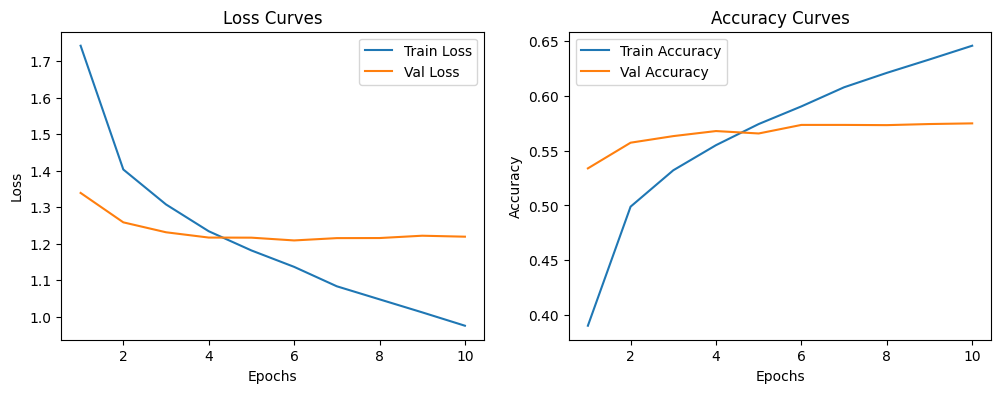

In [11]:
# the loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Train Accuracy")
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label="Val Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


## Saving the Model


In [13]:
model.save("MobileNetV2+DNN.h5")

In [14]:
#loading the model
loaded_model = tf.keras.models.load_model("MobileNetV2+DNN.h5")
